# DT2470 Lab 04: Shazam Wow!

by Bob L. T. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

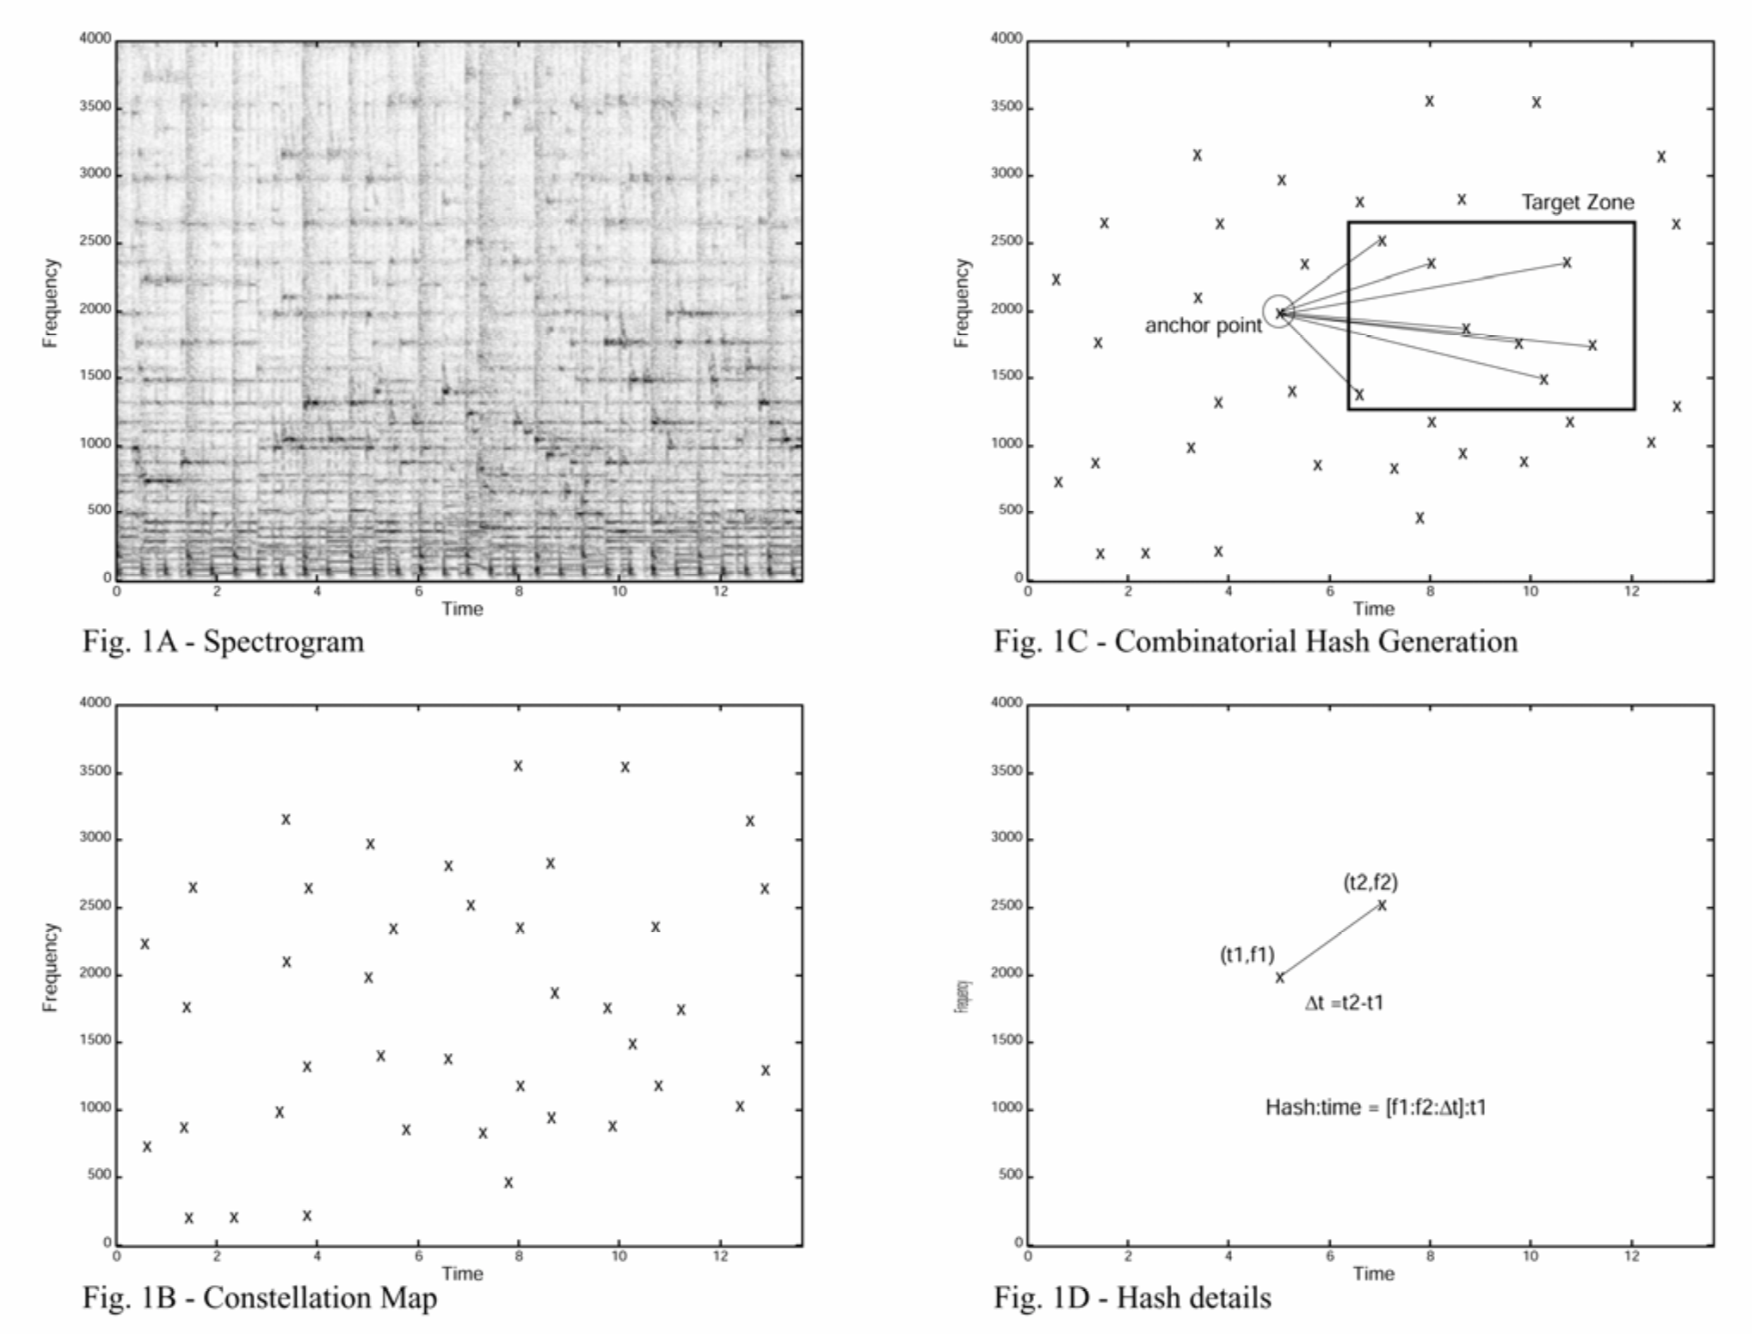

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


In [1]:
# add your code below
## Pick one of the query sound files
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
from pydub import AudioSegment
from scipy import signal
from scipy.fft import fft, fftshift, fftfreq

# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
def get_stft(query, size_fft=8192, duration_ms=50, hopsize_ms=10):
    ## Getting sample rate and samples
    sample_rate = query.frame_rate
    duration = query.duration_seconds
    query_samples = query.get_array_of_samples()
    size_fft=8192

    ## Compute its dB magnitude short-time Fourier transform
    duration_ms = 50 
    hopsize_ms = 10
    window_len = int(duration_ms*sample_rate*1e-3) #Hann windows of duration 50 ms
    hopsize_len = int(hopsize_ms*sample_rate*1e-3) #window hopsize of 10 ms
    zeropadding_len = window_len * 4 #zeropadding to four times the length of the window

    ## zeropadding the signal
    query_samples = np.lib.pad(query_samples, (int(zeropadding_len/2),int(zeropadding_len/2)), 'constant', constant_values=(0, 0))

    f, t, Zxx = signal.stft(query_samples, sample_rate, nperseg=window_len, noverlap=window_len-hopsize_len, nfft=size_fft, boundary=None)
    response = librosa.amplitude_to_db(np.abs(Zxx))
    return f, t, Zxx, response

In [3]:
query_six = AudioSegment.from_file("Q6.wav", format="wav")
sample_rate = query_six.frame_rate
f, t, Zxx_q6, response_q6 = get_stft(query_six)

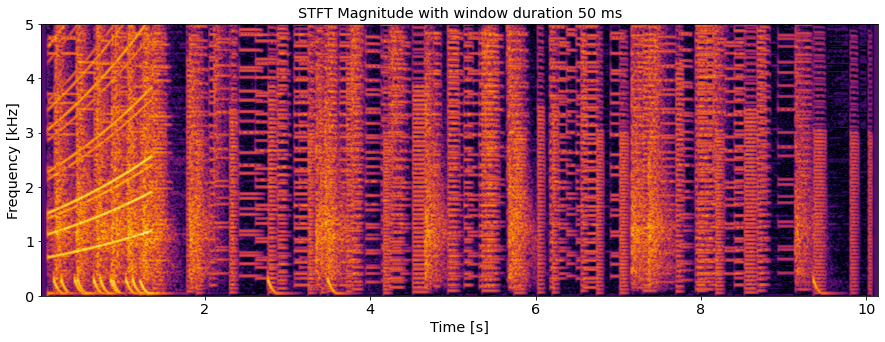

In [4]:
# Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)"
duration_ms=50
plt.figure()
plt.pcolormesh(t, f/1000.0, np.abs(response_q6), cmap='inferno', shading='gouraud')
plt.ylim(0, 5.0)
plt.title(f'STFT Magnitude with window duration {duration_ms} ms')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]')
plt.show()

# 1.2 

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [5]:
def get_anchors(f, t, Zxx, bands=25, delta_t=0.1, sample_rate=22500):
    import math
    delta_f = (sample_rate/2)/bands ##25 bands
    bands_time = math.ceil((t[-1] - t[0])/delta_t) # 102 time 
    
    #segmentation
    #frequency
    frequency_bands = np.array_split(f, bands)
        
    time_bands = np.array_split(t, bands_time)

    frequency_bands_indexes = []
    time_bands_indexes = []

    for i in range(len(frequency_bands)):
        banda = frequency_bands[i] # segment
        frequency_bands_indexes.append((np.where(np.array(f) == banda[0])[0][0], np.where(np.array(f) == banda[-1])[0][0]+1)) # range of index

    for i in range(len(time_bands)):
        banda = time_bands[i]
        time_bands_indexes.append((np.where(np.array(t) == banda[0])[0][0], np.where(np.array(t) == banda[-1])[0][0]+1))

    ##subindexing and finding max
    maximals = []
    maximals_db = []
    maximals_time_and_f = []  ##those are indexes

    for j in range(len(frequency_bands_indexes)):
        for k in range(len(time_bands_indexes)):
            seeds = [frequency_bands_indexes[j][0], time_bands_indexes[k][0]]
            sub_zqq = np.abs(Zxx)[frequency_bands_indexes[j][0]:frequency_bands_indexes[j][1], time_bands_indexes[k][0]:time_bands_indexes[k][1]]
            max_sub_zqq = sub_zqq.max()
            max_xy_p = np.where(sub_zqq == max_sub_zqq)
            max_xy =  (max_xy_p[0][0] + seeds[0],max_xy_p[1][0] + seeds[1]) 
            maximals_time_and_f.append(max_xy)
            max_db = response_q6[max_xy[0], max_xy[1]]
            maximals.append(max_sub_zqq)
            maximals_db.append(max_db)

    #frequency, time indexes
    maximals_time_and_f = np.array(maximals_time_and_f)
    
    return maximals_time_and_f

In [6]:
maximals_time_and_f = get_anchors(f, t, Zxx_q6, sample_rate=sample_rate)

3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x".

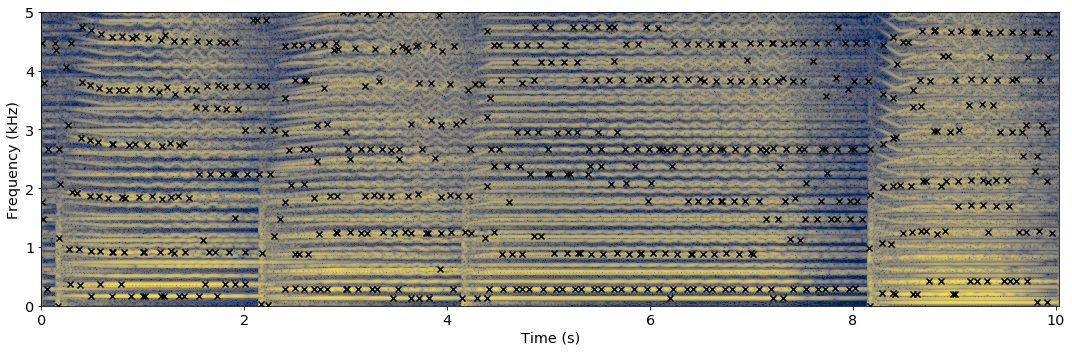

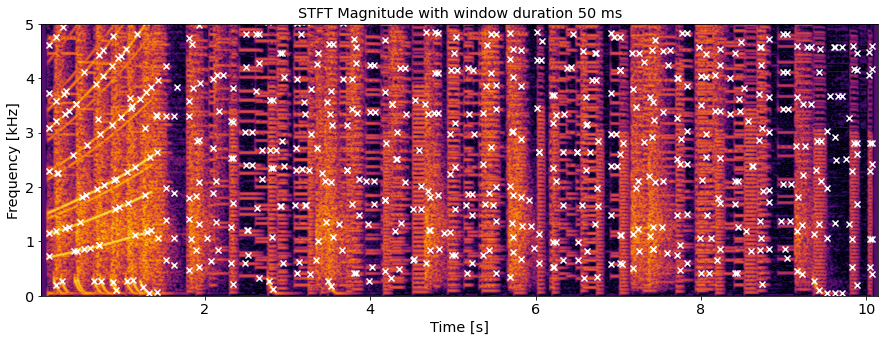

In [7]:
# add your code below
plt.figure()
plt.pcolormesh(t, f/1000, np.abs(response_q6), cmap='inferno', shading='gouraud')
plt.scatter(t[maximals_time_and_f[:, 1]], f[maximals_time_and_f[:, 0]]/1000, marker='x', color='white')
plt.ylim(0, 5.0)
plt.title(f'STFT Magnitude with window duration {duration_ms} ms')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]')
plt.show()

# Write something intelligent about the results
# Most of the times, when you look at the anchors on the plot, it looks like 
# they are signaling patterns in the sonogram, in other words, the anchors
# indicate where a sound is unique because they correlate time, frequency and
# STFT magnitude.

## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [8]:
def get_fingerprints(f, t, maximals_time_and_f):
    #values from indexes
    max_frequencies = f[maximals_time_and_f[:, 0]]
    max_time = t[maximals_time_and_f[:, 1]]
    
    hash_set = []
    fingerprint_set = []
    for anchor in maximals_time_and_f:
        freq_i, time_i =  anchor
        #time and frequency in base anchor
        time = t[time_i]
        freq = f[freq_i]
        zone_t = np.where(np.logical_and(max_time>=time+0.1, max_time<=time+0.6))
        zone_f = np.where(np.logical_and(max_frequencies>=freq*2**-0.5, max_frequencies<=freq*2**0.5))
        zone = np.intersect1d(zone_t, zone_f)
        for i in zone:
            delta_t = max_time[i] - time
            f2 = max_frequencies[i]
            hash_i = (freq, f2, delta_t)
            hash_set.append(hash_i)
            fingerprint_set.append((time, hash_i))

    return tuple(fingerprint_set)

In [9]:
fingerprint_set = get_fingerprints(f, t, maximals_time_and_f)

In [10]:
len(fingerprint_set)

91986

# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: 

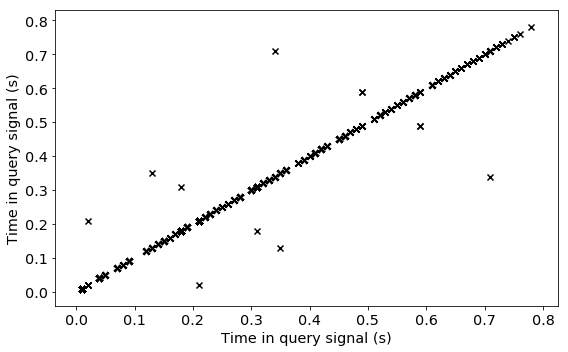



In [11]:
# add your code below
# 5-6 second
fingerprint_q = []
for fgp in fingerprint_set:
    time = fgp[0]
    if 5.0<=time<=6.0:
        fingerprint_q.append(fgp)

fingerprint_q = tuple(fingerprint_q)

In [12]:
def get_matches(fingerprint_d, fingerprint_q):
    eps = 1e-4
    matches = set()
    for fd_i in fingerprint_d:
        for fq_i in fingerprint_q:
            if (fd_i[0], fq_i[0]) in matches: continue
            h1 = fd_i[1]
            h2 = fq_i[1]
            d = abs(h1[0]-h2[0])
            if d > eps: continue # saves a lot of time!!
            d += abs(h1[1]-h2[1])
            if d > eps: continue
            d += abs(h1[2]-h1[2])
            if d <= eps: matches.add((fd_i[0], fq_i[0]))
    return matches

In [13]:
matches_test = get_matches(fingerprint_q, fingerprint_q)

In [14]:
print(len(matches_test))
print(len(fingerprint_q))

115
9371


In [15]:
X, Y = np.array(list(matches_test)).T

Text(0, 0.5, 'Time in query signal (s)')

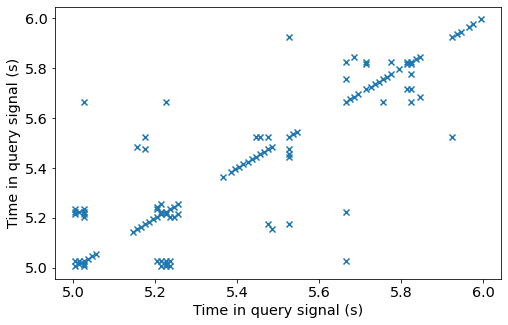

In [16]:
plt.rcParams.update({'figure.figsize': (8, 5)})
plt.figure()
plt.scatter(X, Y, marker='x')
plt.xlabel("Time in query signal (s)")
plt.ylabel("Time in query signal (s)")

#Write something about what you see, and why you see it
# This plot looks almost like a plot from a linear equation with origin zero
# This might be because we are matching the same signal and the matches are 
# going to be at the same time, although we can see that for some different 
# times there are matches, and this might be because the hash is similar at 
# those points

## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

In [ ]:
# add your code below
matches = get_matches(fingerprint_set, fingerprint_q)

Text(0.5, 0, 'Time in original signal (s)')

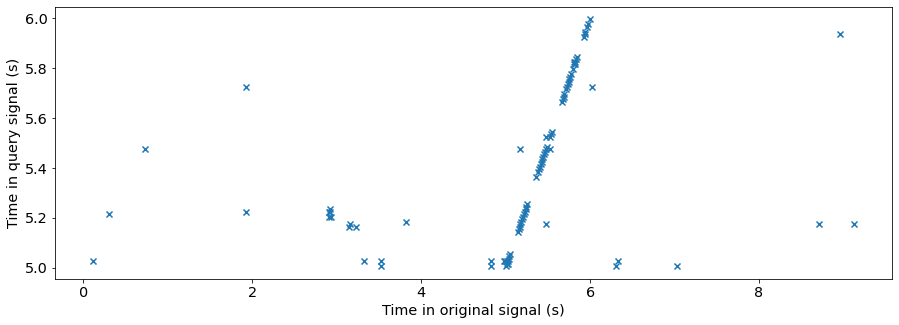

In [28]:
plt.rcParams.update({'figure.figsize': (15, 5)})
plt.figure()
plt.scatter(np.array(list(matches)).T[0], np.array(list(matches)).T[1], marker='x')
plt.ylabel("Time in query signal (s)")
plt.xlabel("Time in original signal (s)")

#write something about the results

# Fd spans for more time than Fq, but Fq in our case corresponds to the second 5 
# to 6 in Fd, which is when we find the linear line. As always, since it is the 
# same song, there are going to be some other matching hashes, but not as much
# as with that specific time

## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

In [35]:
# add your code below
query_one = AudioSegment.from_file("Q1.wav", format="wav")
f_q1, t_q1, Zxx_q1, response_q1 = get_stft(query_one)
anchors_q1 = get_anchors(f_q1, t_q1, Zxx_q1)
fingerprint_d = get_fingerprints(f_q1, t_q1, anchors_q1)
matches_61 = get_matches(fingerprint_d, fingerprint_q)

Text(0.5, 0, 'Time in original signal (s)')

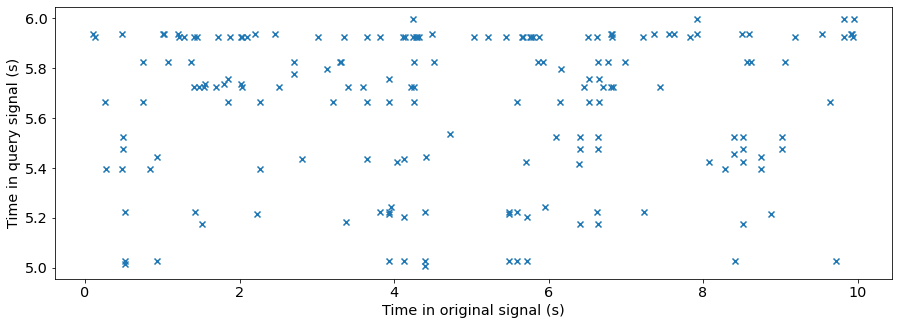

In [36]:
plt.figure()
plt.scatter(np.array(list(matches_61)).T[0], np.array(list(matches_61)).T[1], marker='x')
plt.ylabel("Time in query signal (s)")
plt.xlabel("Time in original signal (s)")

#As above, write something about the results
#Since these are not the same songs, we are not going to find the same line
# we got on the previous plots, but since the songs come from the same genre, 
# we can see some points with matching hashes along the way, but with no
# linear time correlation

# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.